In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.sqrt import UnarySqrt
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def test(rng="Sobol", 
         mode="unipolar", 
         bitwidth=8, 
         jk_trace=False, 
         emit=True, 
         total_cnt=100, 
         depth_kernel=1, 
         depth_emit=3, 
         depth_sync=2, 
         savepdf=False):
    stype = torch.float
    randtype = torch.float
    
    print("========================================================")
    print(mode)
    print("========================================================")
    # all input values are non-negative
    low_bound = 0
    if mode is "unipolar":
        up_bound = 2**bitwidth
    elif mode is "bipolar":
        low_bound = 0
        up_bound = 2**(bitwidth-1)

    input_list = []
    for input_val in range(low_bound, up_bound+1, 1):
        input_list.append(input_val)
    
    input = torch.tensor(input_list).type(torch.float).div(up_bound).to(device)

    dut_sqrt = UnarySqrt(mode=mode, 
                         jk_trace=jk_trace, 
                         depth_kernel=depth_kernel, 
                         rng="Sobol", 
                         rng_dim=4, 
                         emit=emit, 
                         depth_emit=depth_emit, 
                         depth_sync=depth_sync, 
                         stype=torch.float).to(device)

    output = torch.sqrt(input).to(device)
    outputPE = ProgressiveError(output, mode=mode).to(device)
    
    inputPE  = ProgressiveError(input,  mode=mode).to(device)
    inputSRC = SourceGen(input, bitwidth, mode=mode, randtype=randtype)().to(device)
    
    result_pe_total = []
    for rand_idx in range(1, total_cnt+1):
        inputRNG = RNG(bitwidth, rand_idx, rng, randtype)().to(device)
        inputBS = BSGen(inputSRC, inputRNG, stype).to(device)
        with torch.no_grad():
            start_time = time.time()
            for i in range(2**bitwidth):
                input_bs = inputBS(torch.tensor([i]))
                inputPE.Monitor(input_bs)

                ouyput_bs = dut_sqrt(input_bs)
                outputPE.Monitor(ouyput_bs)
        
        # get the result for different rng
        result_pe = outputPE()[1].cpu().numpy()
        result_pe = result_pe.flatten()
        result_pe_total.append(result_pe)
    
    # get the result for different rng
    result_pe_total = np.array(result_pe_total)
    
    #######################################################################
    # check the error of all simulation
    #######################################################################
    print("RMSE:{:1.4}".format(math.sqrt(np.mean(result_pe_total**2))))
    print("MAE: {:1.4}".format(np.mean(np.abs(result_pe_total))))
    print("bias:{:1.4}".format(np.mean(result_pe_total)))
    print("max: {:1.4}".format(np.max(result_pe_total)))
    print("min: {:1.4}".format(np.min(result_pe_total)))

    #######################################################################
    # check the error according to input value
    #######################################################################
    max_total = np.max(result_pe_total, axis=0)
    min_total = np.min(result_pe_total, axis=0)
    median_total = np.median(result_pe_total, axis=0)
    
    axis_len = outputPE()[1].size()[0]
    input_x_axis = []
    for axis_index in range(axis_len):
        input_x_axis.append((axis_index/(axis_len-1)*(up_bound-low_bound)+low_bound)/up_bound)
    fig, ax = plt.subplots()
    ax.fill_between(input_x_axis, max_total, median_total, facecolor="red", alpha=0.75)
    ax.fill_between(input_x_axis, median_total, min_total, facecolor="blue", alpha=0.75)
    # ax.plot(input_x_axis, max_total, label='Max error')
    ax.plot(input_x_axis, median_total, label='Median error', color="black", linewidth=1)
    # ax.plot(input_x_axis, min_total, label='Min error')
    plt.tight_layout()
    plt.xlabel('Input value', fontsize=18)
    plt.ylabel('Output error', fontsize=18)
    plt.ylim(-0.25, 0.55)
    fig.set_size_inches(4, 2)
    if savepdf is True:
        if emit is True:
            plt.savefig(mode+"-bw"+str(bitwidth)+"-bit"+"-emitting"+"-s"+str(depth_sync)+"-k"+str(depth_kernel)+"-e"+str(depth_emit)+".pdf")
        else:
            if jk_trace is True:
                plt.savefig(mode+"-bw"+str(bitwidth)+"-bit"+"-inserting-JK"+".pdf")
            else:
                plt.savefig(mode+"-bw"+str(bitwidth)+"-bit"+"-inserting-IS"+"-k"+str(depth_kernel)+".pdf")
    plt.show()
    plt.close()

# Following code is to test the best configuration for bit-emit sqrt
## The conclusion is that depth_kernel=1, depth_emit=3, depth_sync=2 is the best for different source rngs

111
unipolar
RMSE:0.06206
MAE: 0.04031
bias:-0.03014
max: 0.04209
min: -0.17


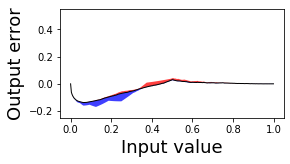

121
unipolar
RMSE:0.06206
MAE: 0.04031
bias:-0.03014
max: 0.04209
min: -0.17


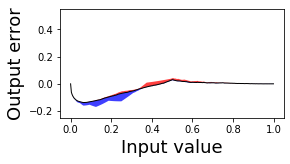

122
unipolar
RMSE:0.05029
MAE: 0.03846
bias:0.02811
max: 0.1178
min: -0.1104


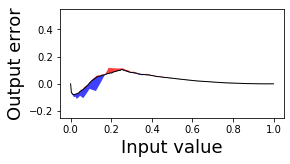

132
unipolar
RMSE:0.05029
MAE: 0.03846
bias:0.02811
max: 0.1178
min: -0.1104


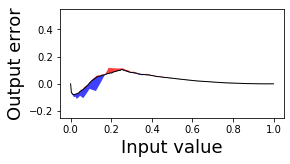

133
unipolar
RMSE:0.07837
MAE: 0.05575
bias:0.05369
max: 0.1977
min: -0.08203


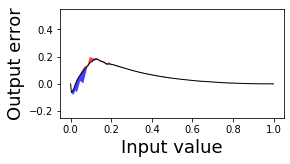

144
unipolar
RMSE:0.09905
MAE: 0.06789
bias:0.06706
max: 0.2659
min: -0.08058


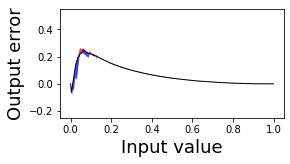

211
unipolar
RMSE:0.06282
MAE: 0.02954
bias:0.02439
max: 0.5
min: -0.1559


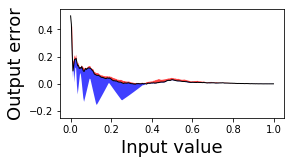

221
unipolar
RMSE:0.06175
MAE: 0.03173
bias:0.0276
max: 0.5
min: -0.1559


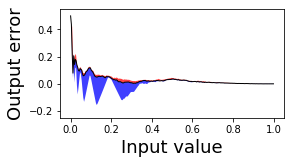

222
unipolar
RMSE:0.05805
MAE: 0.04421
bias:0.03559
max: 0.125
min: -0.08303


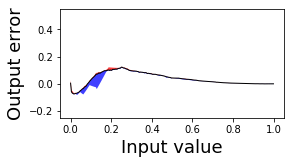

232
unipolar
RMSE:0.05805
MAE: 0.04421
bias:0.03559
max: 0.125
min: -0.08303


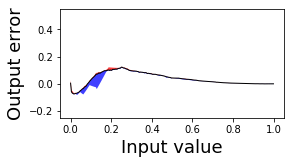

233
unipolar
RMSE:0.08585
MAE: 0.06159
bias:0.05997
max: 0.2094
min: -0.05977


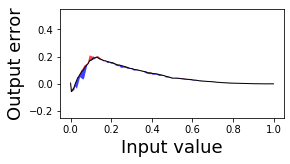

244
unipolar
RMSE:0.1052
MAE: 0.07343
bias:0.07277
max: 0.2796
min: -0.05977


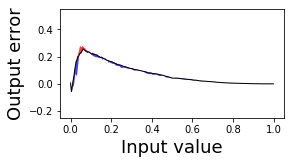

411
unipolar
RMSE:0.1207
MAE: 0.06921
bias:0.06917
max: 0.5
min: -0.001951


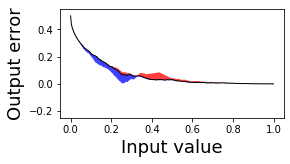

421
unipolar
RMSE:0.1265
MAE: 0.07571
bias:0.07568
max: 0.5
min: -0.001951


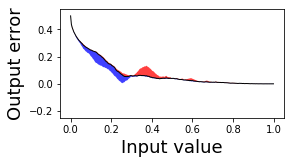

422
unipolar
RMSE:0.1038
MAE: 0.07254
bias:0.0724
max: 0.5117
min: -0.04297


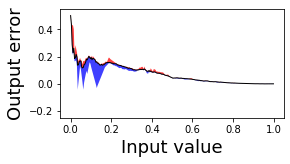

432
unipolar
RMSE:0.08894
MAE: 0.0654
bias:0.06453
max: 0.2193
min: -0.05469


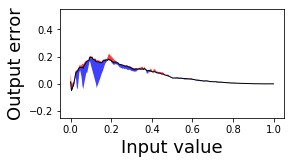

433
unipolar
RMSE:0.1015
MAE: 0.07255
bias:0.07154
max: 0.2446
min: -0.05469


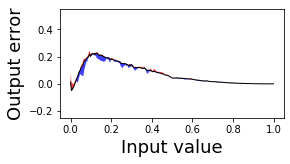

444
unipolar
RMSE:0.1168
MAE: 0.08255
bias:0.08213
max: 0.2854
min: -0.05469


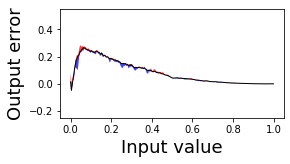

In [5]:
rng="Sobol"
mode="unipolar"
print("111")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=1, depth_sync=1)
print("121")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=2, depth_sync=1)
print("122")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=2, depth_sync=2)
print("132")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=3, depth_sync=2)
print("133")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=3, depth_sync=3)
print("144")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=4, depth_sync=4)
print("211")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=1, depth_sync=1)
print("221")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=2, depth_sync=1)
print("222")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=2, depth_sync=2)
print("232")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=3, depth_sync=2)
print("233")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=3, depth_sync=3)
print("244")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=4, depth_sync=4)
print("411")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=1, depth_sync=1)
print("421")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=2, depth_sync=1)
print("422")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=2, depth_sync=2)
print("432")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=3, depth_sync=2)
print("433")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=3, depth_sync=3)
print("444")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=4, depth_sync=4)

111
bipolar
RMSE:0.07609
MAE: 0.04852
bias:-0.04673
max: 0.03739
min: -0.1739


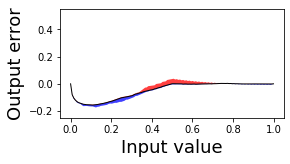

121
bipolar
RMSE:0.07609
MAE: 0.04852
bias:-0.04673
max: 0.03739
min: -0.1739


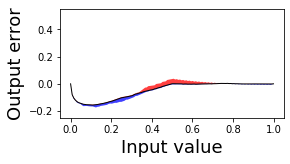

122
bipolar
RMSE:0.04314
MAE: 0.03003
bias:-0.002618
max: 0.04534
min: -0.1484


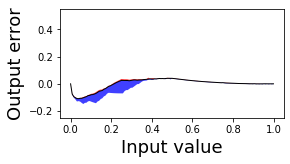

132
bipolar
RMSE:0.04314
MAE: 0.03003
bias:-0.002618
max: 0.04534
min: -0.1484


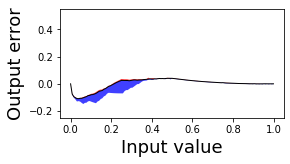

133
bipolar
RMSE:0.05444
MAE: 0.04057
bias:0.03332
max: 0.1451
min: -0.1143


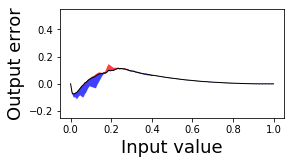

144
bipolar
RMSE:0.08099
MAE: 0.05719
bias:0.05526
max: 0.2212
min: -0.1016


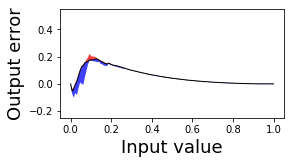

211
bipolar
RMSE:0.05222
MAE: 0.01998
bias:-0.001787
max: 0.5
min: -0.1218


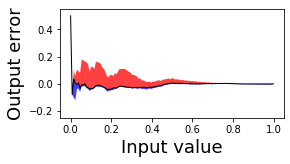

221
bipolar
RMSE:0.0513
MAE: 0.02045
bias:-0.007402
max: 0.5
min: -0.1218


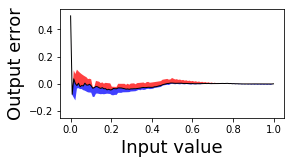

222
bipolar
RMSE:0.04162
MAE: 0.03006
bias:0.003014
max: 0.07373
min: -0.1484


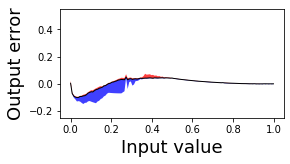

232
bipolar
RMSE:0.04162
MAE: 0.03006
bias:0.003014
max: 0.07373
min: -0.1484


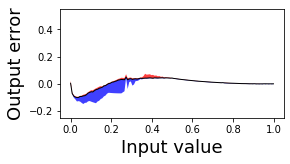

233
bipolar
RMSE:0.05613
MAE: 0.04176
bias:0.03465
max: 0.1451
min: -0.1143


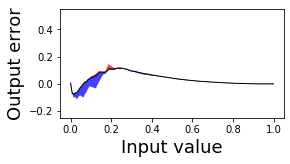

244
bipolar
RMSE:0.08316
MAE: 0.05856
bias:0.05664
max: 0.2212
min: -0.1016


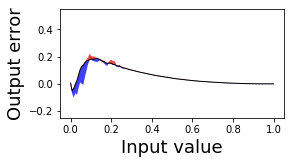

411
bipolar
RMSE:0.1131
MAE: 0.0602
bias:0.05957
max: 0.5
min: -0.007782


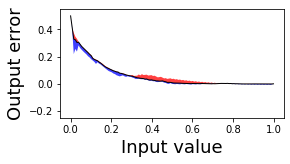

421
bipolar
RMSE:0.1101
MAE: 0.05836
bias:0.05791
max: 0.5
min: -0.007782


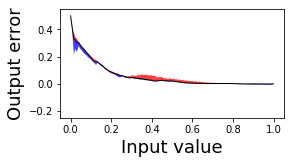

422
bipolar
RMSE:0.0712
MAE: 0.0384
bias:0.03283
max: 0.5078
min: -0.1301


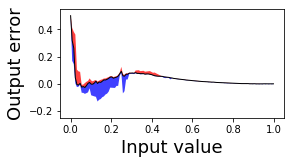

432
bipolar
RMSE:0.04672
MAE: 0.03497
bias:0.02118
max: 0.125
min: -0.125


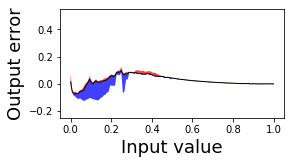

433
bipolar
RMSE:0.06599
MAE: 0.04825
bias:0.04229
max: 0.1451
min: -0.09084


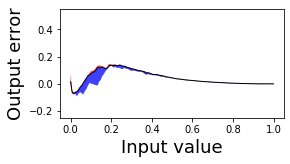

444
bipolar
RMSE:0.09094
MAE: 0.06391
bias:0.06239
max: 0.2212
min: -0.07812


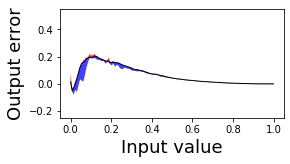

In [6]:
rng="Sobol"
mode="bipolar"
print("111")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=1, depth_sync=1)
print("121")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=2, depth_sync=1)
print("122")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=2, depth_sync=2)
print("132")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=3, depth_sync=2)
print("133")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=3, depth_sync=3)
print("144")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=4, depth_sync=4)
print("211")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=1, depth_sync=1)
print("221")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=2, depth_sync=1)
print("222")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=2, depth_sync=2)
print("232")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=3, depth_sync=2)
print("233")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=3, depth_sync=3)
print("244")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=4, depth_sync=4)
print("411")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=1, depth_sync=1)
print("421")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=2, depth_sync=1)
print("422")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=2, depth_sync=2)
print("432")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=3, depth_sync=2)
print("433")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=3, depth_sync=3)
print("444")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=4, depth_sync=4)